In [1]:
# Imports
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import sys
import matplotlib.pyplot as plt
from master_data_functions.functions import *
from master_models.pretrained import pretrained_model
import lime
%load_ext autoreload
%autoreload 2

/home/geir/git/master_analysis/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/geir/git/master_analysis/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/geir/git/master_analysis/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/geir/git/master_analysis/venv/lib/pyt

In [2]:

# File import
# Sample filenames are:
# CeBr10kSingle_1.txt -> single events, 
# CeBr10kSingle_2.txt -> single events
# CeBr10k_1.txt -> mixed single and double events 
# CeBr10.txt -> small file of 10 samples
# CeBr2Mil_Mix.txt -> 2 million mixed samples of simulated events

# Flag import, since we can now import 200k events from .npy files
from_file = False
if from_file:

    folder = "simulated"
    filename = "CeBr2Mil_Mix.txt"
    num_samples = 2e5
    #folder = "sample"
    #filename = "CeBr10k_1.txt"
    #num_samples = 1e3

    data = import_data(folder=folder, filename=filename, num_samples=num_samples)
    images = data[filename]["images"]
    energies = data[filename]["energies"]
    positions = data[filename]["positions"]
    labels = to_categorical(data[filename]["labels"])
    n_classes = labels.shape[1]
else:
    images = load_feature_representation("images_noscale_200k.npy")
    energies = load_feature_representation("energies_noscale_200k.npy")
    positions = load_feature_representation("positions_noscale_200k.npy")
    labels = load_feature_representation("labels_noscale_200k.npy")

n_classes = labels.shape[1]
print("Number of classes: {}".format(n_classes))
print("Images shape: {}".format(images.shape))
print("Energies shape: {}".format(energies.shape))
print("Positions shape: {}".format(positions.shape))
print("Labels shape: {}".format(labels.shape))


Number of classes: 2
Images shape: (200000, 16, 16, 1)
Energies shape: (200000, 2)
Positions shape: (200000, 4)
Labels shape: (200000, 2)


In [3]:
MODEL_PATH = "../../data/output/models/"
FIGURE_PATH = "../../"
name = "Project-0.97.hdf5"
#name = "DenseNet201-0.92.hdf5"
#name = "VGG16-0.86.hdf5"

loaded_model = tf.keras.models.load_model(MODEL_PATH+name)
#loaded_model = pretrained_model()

# Load model
net = "Project"

# Indices to use for training and test
x_idx = np.arange(images.shape[0])

# Split the indices into training and test sets
train_idx, test_idx, not_used1, not_used2 = train_test_split(x_idx, x_idx, test_size = 0.2)    

test_positions = positions[test_idx]
train_positions = positions[train_idx]
test_energies = energies[test_idx]
train_energies = energies[train_idx]
#x_train = np.concatenate((images[train_idx], images[train_idx], images[train_idx]), axis=-1)
#x_test = np.concatenate((images[test_idx], images[test_idx], images[test_idx]), axis=-1)
x_train = images[train_idx]
x_test = images[test_idx]
y_test = labels[test_idx]
y_train = labels[train_idx]


y_true = y_test.argmax(axis=-1)
tmp_predicted = loaded_model.predict(x_test[20:21])
y_pred = tmp_predicted.argmax(axis=-1)

# indices, relative distances and relative energies for test set
single_indices, double_indices, close_indices = event_indices(test_positions)
rel_distance_test = relative_distance(test_positions)
energy_diff_test = energy_difference(test_energies)
rel_energy_test = relative_energy(test_energies)


W0226 18:12:45.713372 140159523157824 deprecation.py:323] From /home/geir/git/master_analysis/venv/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


3


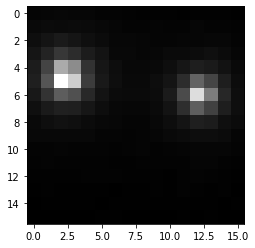

In [10]:
lime_idx = 25000
plt.imshow(images[test_idx][lime_idx].reshape((16,16)), cmap='gray')
print(len(images[test_idx][lime_idx].shape))

In [26]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm

explainer = lime_image.LimeImageExplainer()
seg = SegmentationAlgorithm(
    algo_type='slic',
    multichannel=False
)
explanation = explainer.explain_instance(
    x_test[lime_idx], 
    loaded_model.predict, 
    hide_color=0, 
    num_samples=1000,
    segmentation_fn=seg
)

100% |########################################################################|


temp shape:  (16, 16, 1)
mask shape:  (16, 16, 1)


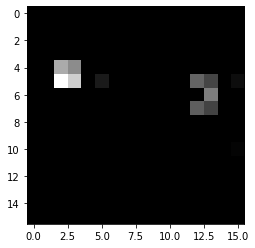

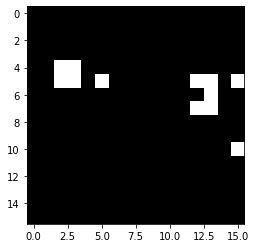

ValueError: NumPy boolean array indexing assignment cannot assign 3 input values to the 38 output values where the mask is true

In [22]:
from skimage.segmentation import mark_boundaries
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], 
    positive_only=True, 
    num_features=5, 
    hide_rest=True)
print("temp shape: ", temp.shape)
print("mask shape: ", mask.shape)
plt.imshow(temp[:,:,0], cmap='gray')
plt.show()
plt.imshow(mask[:,:,0], cmap='gray')
plt.show()
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))